In [55]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid")

# CERN modules
import fillingpatterns as fp


In [2]:
# Load filling scheme
fname = "../master_jobs/filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)



____________________

Scheme name: 

   N. collisions
ATLAS/CMS:     1960 (+0.0%)
LHCb:          1886 (+0.0%)
ALICE:         1178 (+0.0%)

N. bunches:    1972

N. injections: 12

Unused:        122 slots
               (3.4% LHC)

Patterns from SPS:
[12]
[56, 56, 56, 56]
[56]

Injection len: <map object at 0x7fd2ec1fa260>

Gaps = [36, 70, 7, 58, 31]
Abort gap: 121


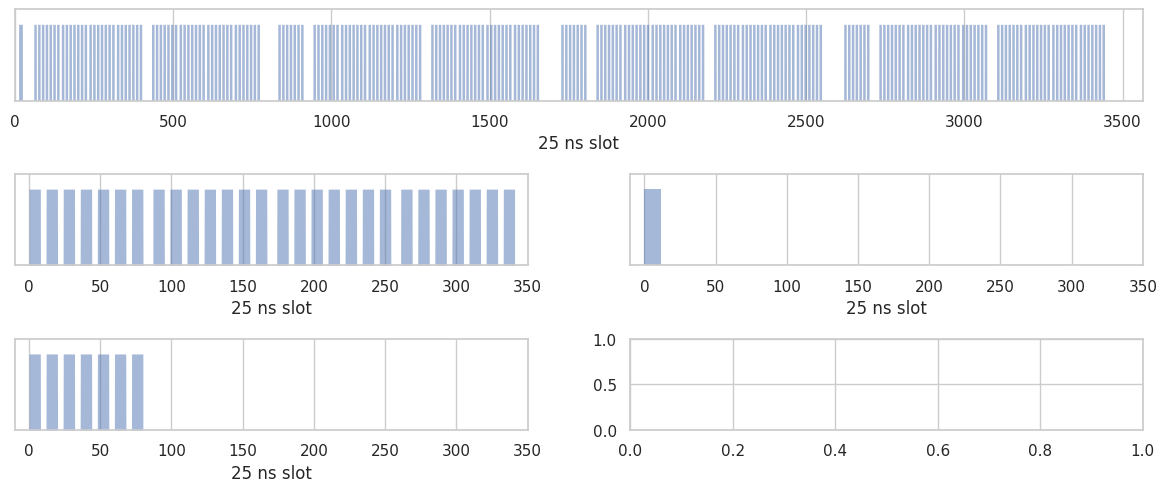

In [3]:

ref_ATLAS = patt.n_coll_ATLAS
ref_LHCb = patt.n_coll_LHCb
ref_ALICE = patt.n_coll_ALICE


print('\n____________________\n')
print('Scheme name: '+fname.split('.')[0])

print('\n   N. collisions')
print('ATLAS/CMS:     %d (%+.1f'%(patt.n_coll_ATLAS, 100*(float(patt.n_coll_ATLAS)/ref_ATLAS-1.))+'%)')
print('LHCb:          %d (%+.1f'%(patt.n_coll_LHCb, 100*(float(patt.n_coll_LHCb)/ref_LHCb-1.))+'%)')
print('ALICE:         %d (%+.1f'%(patt.n_coll_ALICE, 100*(float(patt.n_coll_ALICE)/ref_ALICE-1.))+'%)')

print('\nN. bunches:    %d'%patt.b1.n_bunches)
print('\nN. injections: %d'%(patt.b1.n_injections))
print('\nUnused:        %d slots'%(patt.b1.n_unused_slots))
print('               (%.1f'%patt.b1.inefficiency_perc+'% LHC)')
print('\nPatterns from SPS:')
for pp in patt.b1.inj_composition_types:
    print('%s'%repr(list(pp)))
print('\nInjection len: %s'%repr(map(len, patt.b1.inj_pattern_types)))
print('\nGaps = %s'%repr(list(set(patt.b1.gap_lengths))))
print('Abort gap: %s'%repr(patt.b1.agap_length))

fig1 = plt.figure(1, figsize=(1.5*8, .9*6))
ax = plt.subplot2grid(shape=(3,2), loc=(0,0),
        rowspan=1, colspan=2, fig=fig1)

axinj_list = [
    plt.subplot2grid(shape=(3,2), loc=(1,0),
        rowspan=1, colspan=1, fig=fig1),
    plt.subplot2grid(shape=(3,2), loc=(2,0),
        rowspan=1, colspan=1, fig=fig1),
    plt.subplot2grid(shape=(3,2), loc=(1,1),
        rowspan=1, colspan=1, fig=fig1),
    plt.subplot2grid(shape=(3,2), loc=(2,1),
        rowspan=1, colspan=1, fig=fig1),
    ]

x_pattern = np.arange(0, len(patt.b1.pattern), 0.1)
y_pattern = 0.*x_pattern
for ii, filled in enumerate(patt.b1.pattern):
    if filled>0.5:
        y_pattern[np.logical_and(x_pattern>=ii, x_pattern<(ii+1))] = 1.

ax.fill_between(x = x_pattern, y1=y_pattern, alpha=0.5, linewidth=0., edgecolor='k')
ax.set_ylim(0, 1.2)
ax.set_yticks([])
ax.set_xlim(0, 3564)
ax.set_xlabel('25 ns slot')

fig1.suptitle(fname.split('.')[0])
fig1.subplots_adjust(left=.03, right=.97, bottom=.12, top=.9, hspace=.8)

for i_plot, i_inj in enumerate(np.argsort(patt.b1.inj_nbun_types)[::-1]):

    this_patt = patt.b1.inj_pattern_types[i_inj]
    thisax = axinj_list[i_plot]

    x_pattern = np.arange(0, len(this_patt), 0.1)
    y_pattern = 0.*x_pattern
    for ii, filled in enumerate(this_patt):
        if filled>0.5:
            y_pattern[np.logical_and(x_pattern>=ii,
                        x_pattern<(ii+1))] = 1.

    thisax.fill_between(x = x_pattern, y1=y_pattern,
                alpha=0.5, linewidth=0., edgecolor='k')
    thisax.set_ylim(0, 1.2)
    thisax.set_yticks([])
    thisax.set_xlim(-10, 350)
    thisax.set_xlabel('25 ns slot')

    if i_plot == 3:
        break

#patt.to_csv("../master_jobs/filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.csv")

Computing collision schedules...
Done Beam 1
Done Beam 2


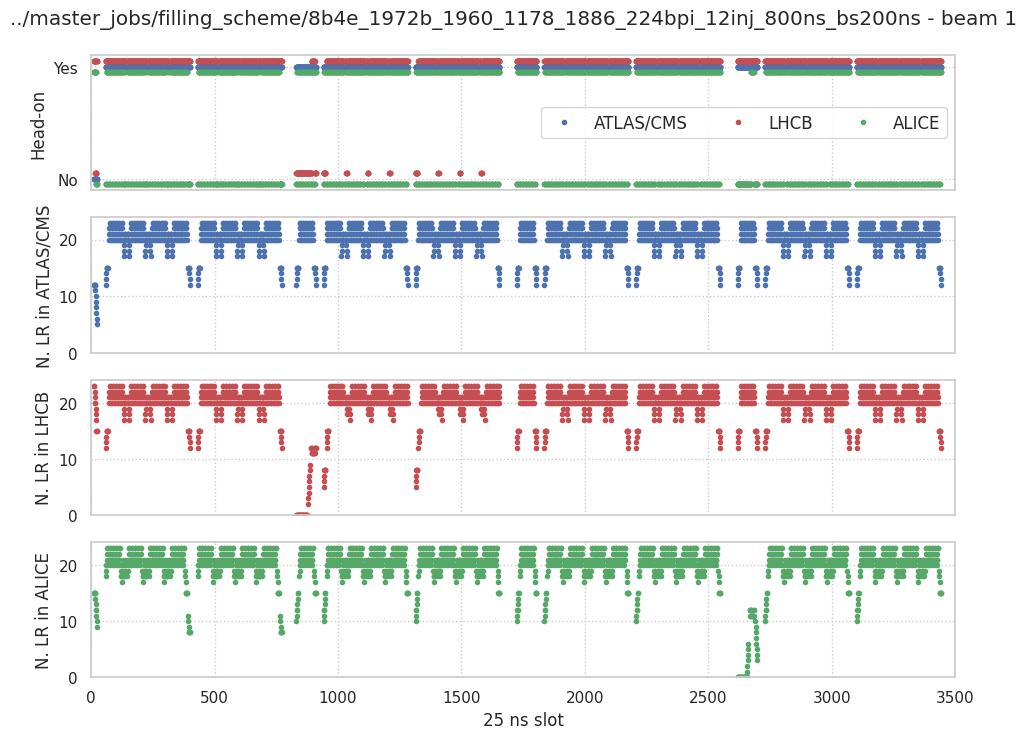

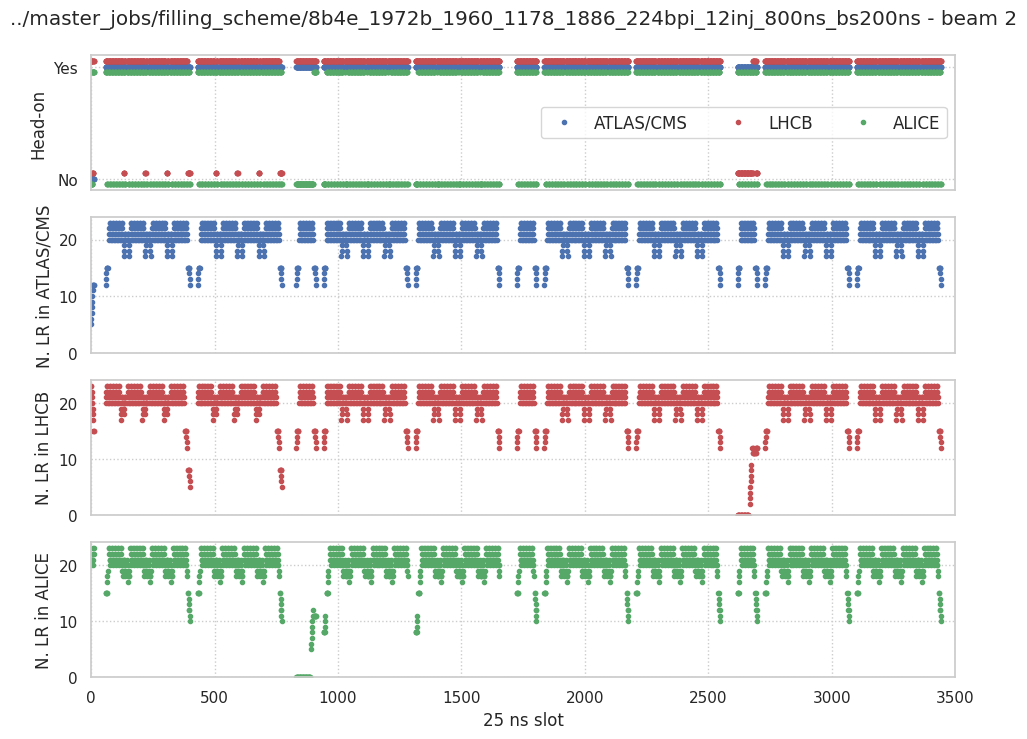

In [4]:
# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=16)

#########
# Plots #
#########

for ib, beam in zip([1, 2], [patt.b1, patt.b2]):

    bbs = beam.bb_schedule

    fig1 = plt.figure(100 + ib, figsize=(6.4*1.5, 1.6*4.8))
    ax1 = fig1.add_subplot(4, 1, 1)
    ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
    ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
    ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)

    ax1.plot(bbs['collides in ATLAS/CMS'], '.', color='b', label='ATLAS/CMS')
    ax1.plot(0.05 +bbs['collides in LHCB'], '.', color='r', label='LHCB')
    ax1.plot(-0.05 + bbs['collides in ALICE'],'.', color='g', label='ALICE')
    ax1.legend(ncol=3, loc='center right', fontsize='medium')

    ax1.plot(bbs['collides in ATLAS/CMS'], '.', color='b')
    ax1.plot(0.05 +bbs['collides in LHCB'], '.', color='r')
    ax1.plot(-0.05 + bbs['collides in ALICE'],'.', color='g')

    ax2.plot(bbs['# of LR in ATLAS/CMS'], '.', color='b')
    ax3.plot(bbs['# of LR in LHCB'], '.', color='r')
    ax4.plot(bbs['# of LR in ALICE'], '.', color='g')

    ax1.set_ylabel('Head-on')
    ax2.set_ylabel('N. LR in ATLAS/CMS')
    ax3.set_ylabel('N. LR in LHCB')
    ax4.set_ylabel('N. LR in ALICE')

    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['No', 'Yes'])
    ax4.set_xlim(0, 3500)
    ax4.set_xlabel('25 ns slot')

    for aa in [ax1, ax2, ax3]:
        aa.tick_params(labelbottom=False)

    for aa in [ax1, ax2, ax3, ax4]:
        aa.grid(True, linestyle=':')

    for aa in [ax2, ax3, ax4]:
        aa.set_ylim(bottom=0)

    fig1.subplots_adjust(left=.06, right=.96, top=.92)
    fig1.suptitle(patt.scheme_name + ' - ' + beam.beam_name)

    #fig1.savefig(fname.split('.csv')[0] + f"_{beam.beam_name.replace(' ', '')}_bb_summary.png", dpi=200)

plt.show()

/afs/cern.ch/work/c/cdroin/private/DA_study/miniconda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


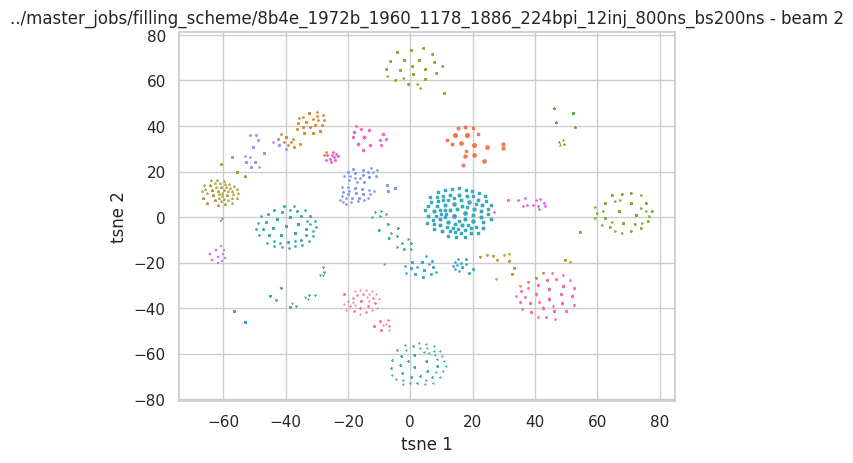

In [57]:
# Cluster the bunches according to the bb schedule
# 6 coordinates contained in bbs dataframe:
# 1. collides in ATLAS/CMS
# 2. collides in LHCB
# 3. collides in ALICE
# 4. # of LR in ATLAS/CMS
# 5. # of LR in LHCB
# 6. # of LR in ALICE
bbs = patt.b1.bb_schedule
# Project bunches in 2D using umap
array_bunches = np.array([bbs['collides in ATLAS/CMS'],
                            bbs['collides in LHCB'],
                            bbs['collides in ALICE'],
                            bbs['# of LR in ATLAS/CMS'],
                            bbs['# of LR in LHCB'],
                            bbs['# of LR in ALICE']], dtype=np.float32).T
# Add some noise to the data
#array_bunches += np.random.normal(0, 0.001, array_bunches.shape)

scaled_array_bunches = StandardScaler().fit_transform(array_bunches)


tsne = manifold.TSNE(n_components=2, perplexity = 80, early_exaggeration =150, random_state = 1, metric = 'manhattan')
array_bunches_2d = tsne.fit_transform(scaled_array_bunches)
#for random_state in range(20):
    #reducer = umap.UMAP(random_state=random_state)
    #array_bunches_2d = reducer.fit_transform(scaled_array_bunches)

    # Find the optimal number of clusters with elbow methods and kmeans
    # inertia = []
    # for k in range(1, 20):
    #     kmeans = KMeans(n_clusters=k, random_state=0).fit(array_bunches_2d)
    #     inertia.append(kmeans.inertia_)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(range(1, 20), inertia)
    # ax.axvline(x=14, color='r', linestyle='--')
    # ax.set_xlabel('k')
    # ax.set_ylabel('inertia')
    # ax.set_title(patt.scheme_name + ' - ' + beam.beam_name)
    # plt.show()


# Cluster the bunches in 14 clusters
n_clusters = 21
kmeans = KMeans(n_clusters=n_clusters, random_state=30, algorithm = "elkan").fit(array_bunches_2d)
bunches_labels = kmeans.labels_
color_list = sns.color_palette("husl", n_clusters)
marker_list = list(Line2D.markers.keys())
# Plot the clusters in 2D
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(n_clusters):
    ax.scatter(array_bunches_2d[bunches_labels==i, 0],
                array_bunches_2d[bunches_labels==i, 1],
                label=f'cluster {i}', color=color_list[i], s=1, marker = marker_list[i])
#ax.legend()
ax.set_xlabel('tsne 1')
ax.set_ylabel('tsne 2')
ax.set_title(patt.scheme_name + ' - ' + beam.beam_name)
#plt.show()
plt.savefig(f"_{beam.beam_name.replace(' ', '')}_bb_clusters.pdf")

